# **CISC3024 Pattern Recognition Final Project**
## Group Members:
- Huang Yanzhen, DC126732
- Mai Jiajun, DC12785

# 0. Project Setup

## 0.1 Packages & Device

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import numpy as np
import cv2
import os

In [2]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Using device: {device_name}")

Using device: cuda


## 0.2 Global Configurations

In [4]:
path_dataset = "./data/SVHN_mat"
norm_mean = [0.4377, 0.4438, 0.4728]
norm_std = [0.1980, 0.2010, 0.1970]

# 1. Data Processing and Augmentation

## 1.1 Download Datasets
Define dataset class, retrieve dataset.

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import scipy.io as sio

In [6]:
class SVHNDataset(Dataset):
    def __init__(self, mat_file, transform=None):
        data = sio.loadmat(mat_file)
        self.images = np.transpose(data['X'], (3, 0, 1, 2))
        self.labels = data['y'].flatten()
        self.labels[self.labels == 10] = 0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [7]:
transform = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.Rotate(limit=30),
    A.Normalize(mean=norm_mean, std=norm_std),
    ToTensorV2()
])

train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"), transform=transform)
test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"test_32x32.mat"), transform=transform)
extra_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"extra_32x32.mat"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
extra_loader = DataLoader(extra_dataset, batch_size=64, shuffle=False)

print(f"Train Size:{train_dataset.__len__()}\nTest Size:{test_dataset.__len__()}\nExtra Size:{extra_dataset.__len__()}")

Train Size:73257
Test Size:26032
Extra Size:531131


## 1.2 Peak A Data

In [8]:
import random

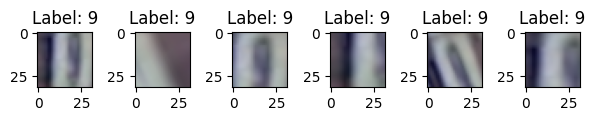

Peaking data from training set of index 68295.
Image Tnesor Size:torch.Size([3, 32, 32])


In [9]:
def unnormalize(img, mean, std):
    """Revert the normalization for visualization."""
    img = img * std + mean
    return np.clip(img, 0, 1)

# Plotting multiple images in a grid
grid_rows, grid_cols = 1, 6

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(6, 6))

peak_index = random.randint(0, train_dataset.__len__()-1)

for i in range(grid_cols):
    img_tensor, label = train_dataset.__getitem__(peak_index)
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    img = unnormalize(img, norm_mean, norm_std)

    ax = axes[i]  # Get subplot axis
    ax.imshow(img)
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

print(f"Peaking data from training set of index {peak_index}.\nImage Tnesor Size:{train_dataset.__getitem__(peak_index)[0].shape}")

# 2. Neuron Network Structure

## 2.1 Specify Model Structure

In [10]:
class SmallVGG(nn.Module):
    def __init__(self, batch_size=32):
        super(SmallVGG, self).__init__()
        self.batch_size = batch_size
        self. conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4
        )
    
        self.fc_layers = nn.Sequential(
            nn.Linear(batch_size * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## 2.2 Initialize with Hyper Parameters

In [11]:
model = SmallVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

## 2.3 Train and Evaluate

In [12]:
def train_and_evaluate(model,
                      train_loader,
                      test_loader,
                      criterion,
                      optimizer,
                      num_epochs=100):
    # Record Losses to plot
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(images)
        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(images)

        test_losses.append(test_loss / len(test_loader))
        print(f"Epoch[{epoch+1}/{num_epochs}], Train Loss:{train_losses[-1]:.4f}, Test Loss:{test_losses[-1]:.4f}")

    return train_losses, test_losses

In [13]:
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), "./models/small_vgg.pth")

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 35.02it/s]


Epoch[1/20], Train Loss:274.6457, Test Loss:231.2000


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.51it/s]


Epoch[2/20], Train Loss:194.7886, Test Loss:162.9517


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.33it/s]


Epoch[3/20], Train Loss:155.9958, Test Loss:144.1323


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.48it/s]


Epoch[4/20], Train Loss:142.6832, Test Loss:133.3954


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.93it/s]


Epoch[5/20], Train Loss:134.5424, Test Loss:128.3368


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 33.71it/s]


Epoch[6/20], Train Loss:130.5997, Test Loss:125.6240


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:16<00:00, 34.48it/s]


Epoch[7/20], Train Loss:125.5485, Test Loss:120.7639


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.53it/s]


Epoch[8/20], Train Loss:124.1696, Test Loss:118.4872


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.15it/s]


Epoch[9/20], Train Loss:120.9612, Test Loss:113.3991


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.24it/s]


Epoch[10/20], Train Loss:118.6144, Test Loss:113.7872


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.48it/s]


Epoch[11/20], Train Loss:117.9692, Test Loss:110.4911


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.40it/s]


Epoch[12/20], Train Loss:115.7035, Test Loss:113.2562


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.87it/s]


Epoch[13/20], Train Loss:115.2380, Test Loss:108.2941


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.21it/s]


Epoch[14/20], Train Loss:114.7385, Test Loss:107.8721


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.81it/s]


Epoch[15/20], Train Loss:112.3307, Test Loss:107.8992


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.98it/s]


Epoch[16/20], Train Loss:111.6271, Test Loss:104.6962


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 29.91it/s]


Epoch[17/20], Train Loss:111.2020, Test Loss:105.5972


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.16it/s]


Epoch[18/20], Train Loss:110.9023, Test Loss:108.3552


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:19<00:00, 30.01it/s]


Epoch[19/20], Train Loss:109.1147, Test Loss:105.0118


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.58it/s]


Epoch[20/20], Train Loss:108.8578, Test Loss:104.3702


## 2.4 Visualize Result

In [23]:
from sklearn.metrics import (confusion_matrix, accuracy_score,
                            precision_score, recall_score,
                            f1_score, roc_auc_score,
                            roc_curve, precision_recall_curve,
                            average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay

### 2.4.1 Epoch-Loss Curves

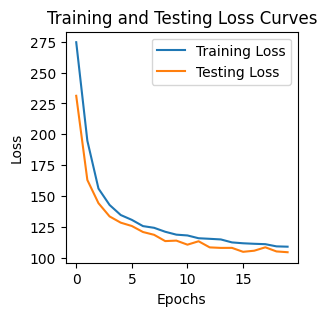

In [14]:
plt.figure(figsize=(3,3))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Curves")
plt.legend()
plt.show()

### 2.4.2 Confusion Matrix

In [14]:
model_state = torch.load("./models/small_vgg.pth")
model = SmallVGG()
model.load_state_dict(model_state)

model.to(device)
model.eval() 
true_labels = []
pred_labels = []
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    pred_labels += nn.functional.softmax(outputs, dim=-1)
    true_labels += labels

D:\Temps\temp\ipykernel_32920\2721227225.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load("./models/small_vgg.pth")
100%|████████████████████████

In [30]:
pred_labels_cpu = [torch.argmax(out_item, dim=0).cpu().item() for out_item in pred_labels]
pred_labels_cpu

[5,
 2,
 1,
 0,
 6,
 1,
 9,
 1,
 1,
 8,
 3,
 6,
 5,
 1,
 4,
 4,
 1,
 6,
 3,
 4,
 2,
 0,
 1,
 9,
 2,
 5,
 4,
 1,
 4,
 1,
 9,
 3,
 5,
 0,
 0,
 1,
 5,
 1,
 1,
 2,
 2,
 1,
 6,
 9,
 5,
 3,
 1,
 2,
 8,
 6,
 9,
 1,
 0,
 1,
 9,
 9,
 4,
 5,
 5,
 5,
 2,
 9,
 2,
 7,
 1,
 0,
 3,
 2,
 3,
 2,
 7,
 5,
 1,
 1,
 4,
 6,
 2,
 8,
 8,
 1,
 1,
 1,
 7,
 1,
 2,
 1,
 7,
 1,
 0,
 1,
 1,
 6,
 6,
 4,
 4,
 4,
 4,
 1,
 7,
 7,
 4,
 5,
 2,
 3,
 2,
 2,
 3,
 1,
 6,
 6,
 3,
 7,
 6,
 2,
 0,
 7,
 2,
 1,
 2,
 2,
 6,
 8,
 1,
 7,
 0,
 0,
 3,
 4,
 9,
 9,
 6,
 2,
 4,
 0,
 8,
 8,
 0,
 1,
 0,
 3,
 1,
 2,
 4,
 6,
 7,
 2,
 1,
 3,
 5,
 3,
 1,
 5,
 2,
 6,
 8,
 9,
 6,
 6,
 4,
 6,
 7,
 0,
 3,
 6,
 1,
 1,
 1,
 2,
 5,
 2,
 7,
 5,
 4,
 2,
 1,
 9,
 2,
 2,
 6,
 1,
 1,
 0,
 7,
 1,
 4,
 8,
 3,
 2,
 1,
 5,
 0,
 2,
 1,
 1,
 2,
 3,
 6,
 1,
 1,
 3,
 2,
 2,
 1,
 5,
 8,
 2,
 1,
 0,
 4,
 7,
 1,
 9,
 1,
 5,
 7,
 3,
 1,
 1,
 1,
 3,
 0,
 1,
 7,
 1,
 2,
 8,
 1,
 2,
 2,
 9,
 2,
 5,
 7,
 6,
 1,
 1,
 4,
 6,
 3,
 1,
 4,
 0,
 1,
 4,
 1,
 7,
 3,
 0,
 3,
 1,


In [31]:
true_labels_cpu = [out_item.cpu().item() for out_item in true_labels]
true_labels_cpu

[5,
 2,
 1,
 0,
 6,
 1,
 9,
 1,
 1,
 8,
 3,
 6,
 5,
 1,
 4,
 4,
 1,
 6,
 3,
 4,
 2,
 0,
 1,
 3,
 2,
 5,
 4,
 1,
 4,
 2,
 8,
 3,
 8,
 6,
 0,
 1,
 5,
 1,
 1,
 2,
 9,
 1,
 6,
 9,
 2,
 6,
 1,
 2,
 0,
 6,
 9,
 1,
 5,
 1,
 9,
 8,
 1,
 5,
 1,
 5,
 2,
 9,
 2,
 4,
 1,
 0,
 6,
 9,
 3,
 2,
 3,
 5,
 1,
 1,
 4,
 6,
 2,
 8,
 3,
 1,
 4,
 1,
 7,
 1,
 2,
 1,
 7,
 1,
 0,
 1,
 4,
 4,
 6,
 4,
 4,
 2,
 8,
 1,
 7,
 7,
 4,
 8,
 2,
 3,
 2,
 2,
 3,
 1,
 8,
 6,
 3,
 7,
 6,
 3,
 0,
 7,
 2,
 7,
 4,
 2,
 8,
 8,
 1,
 7,
 1,
 9,
 3,
 4,
 2,
 9,
 6,
 2,
 6,
 0,
 8,
 2,
 0,
 1,
 0,
 3,
 2,
 2,
 4,
 6,
 7,
 2,
 1,
 3,
 5,
 3,
 1,
 5,
 9,
 1,
 8,
 1,
 2,
 6,
 4,
 6,
 4,
 9,
 3,
 6,
 1,
 0,
 1,
 2,
 5,
 2,
 7,
 5,
 2,
 2,
 1,
 4,
 2,
 9,
 6,
 7,
 1,
 0,
 2,
 1,
 4,
 8,
 3,
 2,
 1,
 6,
 2,
 6,
 1,
 1,
 2,
 3,
 6,
 1,
 1,
 3,
 7,
 2,
 3,
 5,
 6,
 2,
 1,
 0,
 4,
 7,
 1,
 0,
 2,
 3,
 7,
 3,
 1,
 1,
 1,
 2,
 0,
 1,
 7,
 1,
 2,
 9,
 1,
 2,
 2,
 9,
 2,
 5,
 7,
 6,
 1,
 1,
 4,
 9,
 6,
 2,
 7,
 1,
 1,
 4,
 1,
 7,
 3,
 0,
 3,
 6,


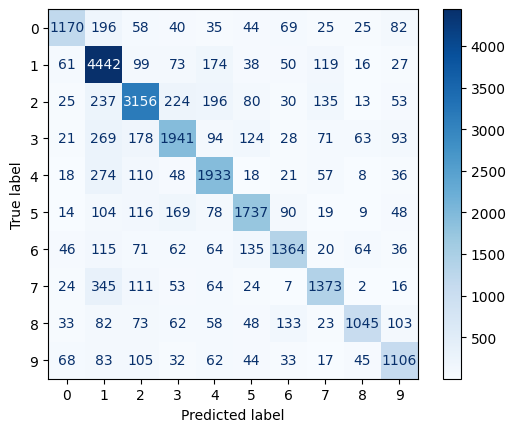

In [33]:
cm = confusion_matrix(true_labels_cpu, pred_labels_cpu)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(0,10))
disp.plot(cmap=plt.cm.Blues)
plt.show()